# 1

In [58]:
import os
import numpy as np
import torch
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms

In [59]:
# Load the pre-trained CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

## CLIP Model Description: `openai/clip-vit-base-patch32`

## 1. Model Architecture

### Vision Encoder
- **Backbone**: Vision Transformer (ViT)
  - Splits input images into **fixed-size patches** (32x32 pixels per patch).
  - Each patch is flattened and embedded into a **512-dimensional vector**.
  - The embeddings are passed through a **Transformer encoder**.
- **Number of Layers**: 12 Transformer layers.
- **Self-Attention Mechanism**: Each layer uses **multi-head self-attention**.
  - Each attention head has **Key (K)**, **Query (Q)**, and **Value (V)** matrices.
- **Final Output**: A fixed-size feature vector for the image.

### Text Encoder
- **Backbone**: Transformer-based encoder for natural language.
  - Tokenizes the input text and embeds each token into a **512-dimensional vector**.
  - Embeddings are passed through 12 Transformer layers with self-attention.
- **Number of Layers**: 12 Transformer layers.
- **Self-Attention Mechanism**: Similar to the vision encoder, uses multi-head self-attention with K, Q, and V matrices.

### Shared Space
- Both the vision and text encoders project their outputs into a **shared embedding space** using a **linear projection layer**.
- The model computes the similarity (dot product) between image and text embeddings in this space.

---

## 2. Parameter Breakdown
The total number of parameters in `clip-vit-base-patch32` is approximately **149M**. Below is a detailed breakdown:

### Vision Encoder (ViT):
1. **Embedding Layer**:
   - Converts 32x32 patches into 512-dimensional vectors using a linear layer.
   - **Parameters**: \( (32 * 32 * 3) * 512 = 1,572,864 \).

2. **Transformer Layers (12 Layers)**:
   - Each layer consists of:
     - **Multi-Head Attention** (8 heads):
       - Each head has K, Q, and V matrices of size \( 512 * 64 \) (64 = 512 / 8).
       - Total parameters for K, Q, V per layer: \( 3 * (512 * 64) = 98,304 \).
       - Output projection matrix: \( 512 * 512 = 262,144 \).
       - **Total per attention layer**: \( 98,304 + 262,144 = 360,448 \).
     - **Feed-Forward Network**:
       - Two dense layers: \( 512 \to 2048 \to 512 \).
       - **Parameters**: \( 512 * 2048 + 2048 * 512 = 4,194,304 \).
     - **Total parameters per Transformer layer**: \( 360,448 + 4,194,304 = 4,554,752 \).
   - **Total for 12 layers**: \( 4,554,752 * 12 = 54,657,024 \).

3. **Positional Embeddings**:
   - Added to patch embeddings to encode spatial information.
   - **Parameters**: \( 197 * 512 = 100,864 \) (197 = 196 patches + 1 CLS token).

4. **Final Linear Projection**:
   - Projects the 512-dimensional vector into the shared embedding space.
   - **Parameters**: \( 512 * 512 = 262,144 \).

---

### Text Encoder:
1. **Embedding Layer**:
   - Converts input tokens to 512-dimensional vectors.
   - **Parameters**: \( 49,152 * 512 = 25,165,824 \) (Vocabulary size = 49,152).

2. **Transformer Layers (12 Layers)**:
   - Similar to the vision encoder.
   - **Total for 12 layers**: \( 54,657,024 \).

3. **Final Linear Projection**:
   - Projects the 512-dimensional vector into the shared embedding space.
   - **Parameters**: \( 512 * 512 = 262,144 \).

---

## 3. What the Parameters Are Doing

### Vision Encoder:
- **K, Q, V Matrices**:
  - Capture relationships between different patches in the image using attention.
  - Enable the model to understand global and local patterns in the image.
- **Feed-Forward Network**:
  - Introduces non-linearity and combines features across attention heads.
- **Positional Embeddings**:
  - Provide spatial information about the patches to the model.
- **Final Linear Projection**:
  - Maps the vision features into the shared embedding space for similarity computation.

### Text Encoder:
- **K, Q, V Matrices**:
  - Model relationships between words (e.g., syntax, semantics) using self-attention.
- **Feed-Forward Network**:
  - Helps process token-level features and combine contextual information.
- **Final Linear Projection**:
  - Maps the text features into the shared embedding space.

---

## 4. Summary of Parameter Counts
| Component                  | Parameter Count     |
|----------------------------|---------------------|
| Vision Encoder (ViT)       | ~86M               |
| Text Encoder               | ~63M               |
| **Total**                  | ~149M              |

# 2

In [60]:
categories = ["airplane", "car", "chair", "cup", "dog", "donkey", "duck", "hat"]
conditions = ["realistic", "geons", "silhouettes", "blurred", "features"]

In [61]:
# Function to load an image from the dataset
def load_image(image_path):
    return Image.open(image_path)

In [62]:
# Function to extract the category from the image filename
def get_category_from_filename(filename):
    # Convert filename to lowercase and check for categories in the name
    filename_lower = filename.lower()
    for category in categories:
        if filename_lower.startswith(category):
            return category
    return None

In [63]:
# Function to evaluate the model on each image for all categories and conditions
image_paths = []
category_list = []
condition_list = []

def evaluate_model(dataset_path):
    results = {condition: {'correct': 0, 'total': 0} for condition in conditions}
    
    for condition in conditions:
        condition_path = os.path.join(dataset_path, condition)
        
        # Make sure the condition folder exists before proceeding
        if not os.path.exists(condition_path):
            print(f"Warning: {condition_path} does not exist!")
            continue
        
        for img_name in os.listdir(condition_path):
            img_path = os.path.join(condition_path, img_name)
            if img_path.endswith(('.png', '.jpg', '.jpeg')):
                # Extract category from filename
                extracted_category = get_category_from_filename(img_name)
                print(f'{condition}_{img_name} - {extracted_category}')
                if extracted_category is None:
                    continue  # Skip if category cannot be extracted
                
                image_paths.append(img_path)
                category_list.append(extracted_category)
                condition_list.append(condition)
                # Load the image
                image = load_image(img_path)

                # Prepare the text labels (one for each category)
                text_inputs = [f"This is a {cat}" for cat in categories]
                
                # Process the image and text inputs
                inputs = processor(text=text_inputs, images=image, return_tensors="pt", padding=True).to(device)
                
                # Get model outputs
                outputs = model(**inputs)
                
                # Compute similarity scores between image and text embeddings
                logits_per_image = outputs.logits_per_image  # Similarity scores (image vs text)
                probs = logits_per_image.softmax(dim=1)   # Normalize to probabilities
                
                # Get the index of the highest score (max probability)
                predicted_class_idx = torch.argmax(probs, dim=1).item()
                
                # Check if the prediction is correct
                if predicted_class_idx == categories.index(extracted_category):
                    results[condition]['correct'] += 1
                
                # Increment the total count for this condition
                results[condition]['total'] += 1
                        
    return results

In [64]:
dataset_path = "./image_files/image_files/v0"

# Evaluate the model
evaluation_results = evaluate_model(dataset_path)

realistic_AirplaneSide_v1.jpg - airplane
realistic_Airplaneside_v2.jpg - airplane
realistic_AirplaneThree-Quarter_v1.jpg - airplane
realistic_AirplaneThree-Quarter_v3.jpg - airplane
realistic_AirplaneThree-Quarter_V4.jpg - airplane
realistic_CarSide_v1.jpg - car
realistic_Carside_v3.jpg - car
realistic_CarSide_v4.jpg - car
realistic_CarThree-Quarter_v1.jpg - car
realistic_CarThree-Quarter_v2.jpg - car
realistic_Chairside_v1.jpg - chair
realistic_Chairside_v2.jpg - chair
realistic_Chairside_v3.jpg - chair
realistic_ChairThree-Quarter_v1.jpg - chair
realistic_ChairThree-Quarter_v4.jpg - chair
realistic_CupSide_v1.jpg - cup
realistic_CupSide_v2.jpg - cup
realistic_CupThreeQuarter_v1.jpg - cup
realistic_CupThreeQuarter_v2.jpg - cup
realistic_CupThreeQuarter_v3.jpg - cup
realistic_DogSide_V1.jpg - dog
realistic_DogSide_v2.jpg - dog
realistic_DogSide_v4.jpg - dog
realistic_DogThree-Quarter_v2.jpg - dog
realistic_DogThreeQuarter_v3.jpg - dog
realistic_DogThreeQuarter_v4.jpg - dog
realistic_Do

In [65]:
accuracy_values = []
for condition, result in evaluation_results.items():
    accuracy = result['correct'] / result['total'] * 100 if result['total'] > 0 else 0
    print(f"Accuracy for condition '{condition}': {accuracy:.2f}%")
    accuracy_values.append(accuracy)

Accuracy for condition 'realistic': 100.00%
Accuracy for condition 'geons': 49.15%
Accuracy for condition 'silhouettes': 87.50%
Accuracy for condition 'blurred': 64.29%
Accuracy for condition 'features': 80.49%


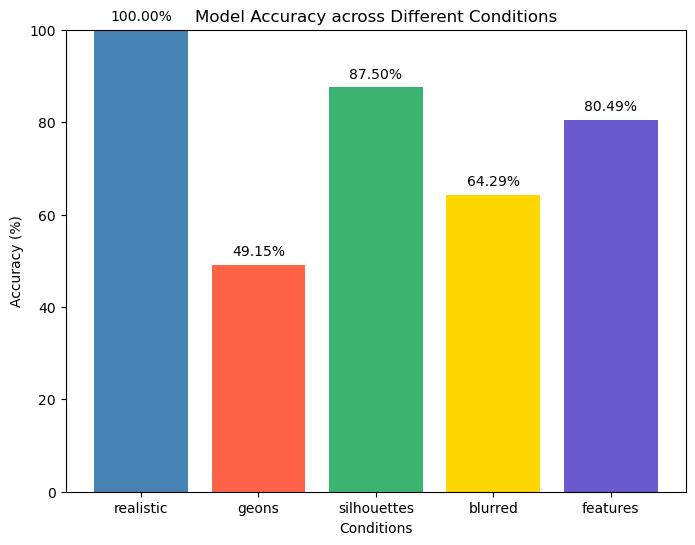

In [66]:
import matplotlib.pyplot as plt

colors = ['#4682B4', '#FF6347', '#3CB371', '#FFD700', '#6A5ACD']
plt.figure(figsize=(8, 6))
plt.bar(conditions, accuracy_values, color=colors)
plt.xlabel('Conditions')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy across Different Conditions')
plt.ylim(0, 100)

for i, value in enumerate(accuracy_values):
    plt.text(i, value + 2, f'{value:.2f}%', ha='center', fontsize=10)

plt.show()

## openai/clip-vit-base-patch32 Model vs Baby Performance Comparison


**Model's Accuracy:**
- **Realistic:** 100.00%
- **Geons:** 49.15%
- **Silhouettes:** 87.50%
- **Blurred:** 64.29%
- **Features:** 80.49%

**Baby's Accuracy:**
- **Realistic:** 84%
- **Geons:** 58%
- **Silhouettes:** 78%
- **Blurred:** 55%
- **Features:** 54%

---

### Analysis:

#### 1. **Better Performance by the Model:**
   - **Realistic:** The model outperforms the baby significantly (100.00% vs. 84%).
   - **Silhouettes:** The model performs better (87.50% vs. 78%).
   - **Blurred:** The model outperforms the baby (64.29% vs. 55%).
   - **Features:** The model performs better by a significant margin (80.49% vs. 54%).

#### 2. **Worse Performance by the Model:**
   - **Geons:** The model performs worse than the baby (49.15% vs. 58%).

---

### Summary of Model Performance:
- The model performs **better** than the baby in **Realistic**, **Silhouettes**, **Blurred**, and **Features** conditions.
- The model performs **worse** than the baby only in the **Geons** condition.
- The model outperforms the baby in **Features** by a large margin (80.49% vs. 54%).

---

### Conclusion:
- The **model performs better** than the baby in all conditions except for **Geons**.
- In **Geons**, the **baby performs better** than the model.
- The model's performance in the **Features** condition is particularly strong, showing a **significant advantage** over the baby.

This suggests that the model, particularly with the CLIP architecture, excels in recognizing more structured patterns (like realistic images, silhouettes, and features) but struggles more with abstract or less defined patterns like **Geons**.


# 3

In [67]:
# Function to extract embeddings from the vision model
def extract_embeddings(image_paths):
    embeddings = []
    loaded_images = []  # List to store loaded images

    for img_path in image_paths:
        try:
            # Load the image
            image = load_image(img_path)
            loaded_images.append(image.convert("RGB").resize((100, 100)))  # Store the loaded image

            # Process the image for the model
            inputs = processor(images=image, return_tensors="pt").to(device)

            # Extract embeddings from the vision model
            with torch.no_grad():
                vision_outputs = model.vision_model(**inputs)
                image_embedding = vision_outputs.pooler_output.squeeze().cpu().numpy()

            embeddings.append(image_embedding)

        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    return np.array(embeddings), loaded_images

In [68]:
# Extract embeddings
embeddings, loaded_images = extract_embeddings(image_paths)

In [69]:
image_df = pd.DataFrame({
        "Condition" : condition_list,
        "Category" : category_list,
        "Image": loaded_images,
    })

In [70]:
category_color_map = {
    "airplane": "#1f77b4",  # Blue
    "car": "#ff7f0e",        # Orange
    "chair": "#2ca02c",      # Green
    "cup": "#d62728",        # Red
    "dog": "#9467bd",        # Purple
    "donkey": "#8c564b",     # Brown
    "duck": "#e377c2",       # Pink
    "hat": "#7f7f7f"         # Gray
}

# Map each row's category to its corresponding color
image_df['Color'] = image_df['Category'].map(category_color_map)

In [71]:
image_df['Image_Array'] = image_df['Image'].apply(lambda img: np.array(img).flatten())

# Stack all the flattened images into a 2D NumPy array
image_data = np.stack(image_df['Image_Array'].values)

# Normalize the image data (optional but recommended)
image_data = image_data / 255.0

In [72]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
from PIL import Image
import numpy as np
import matplotlib.patches as patches

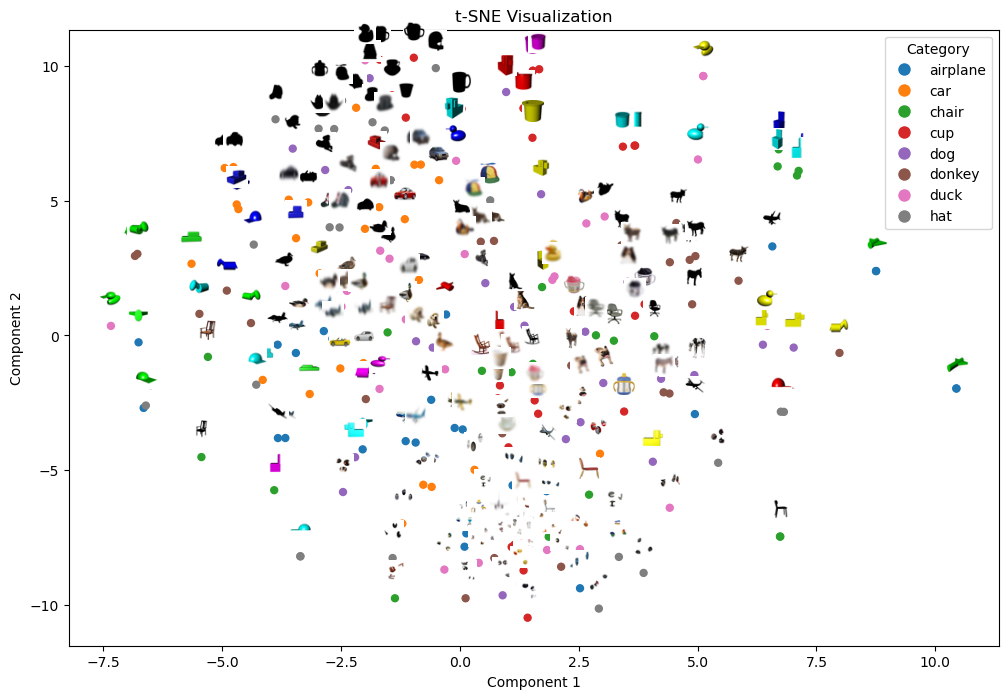

In [73]:
reduced_data_2d_TSNE = TSNE(n_components=2, random_state=42).fit_transform(image_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Add scatter points
scatter = ax.scatter(
    reduced_data_2d_TSNE[:, 0],
    reduced_data_2d_TSNE[:, 1],
    c=image_df['Color'],
    s=25,
    alpha=1,
)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=color)
    for key, color in category_color_map.items()
]
ax.legend(handles=legend_elements, title="Category", loc="best")


# Define the vertical offset for the images
vertical_offset = 1  # Adjust this value as needed

# Add images to the scatter plot
for i, row in image_df.iterrows():
    try:
        # Resize the image for visualization
        image = np.array(row['Image'].resize((24, 24)))
        im = OffsetImage(image, zoom=0.65, alpha=1.0)
        # Position the image above the dot
        ab = AnnotationBbox(
            im,
            (reduced_data_2d_TSNE[i, 0], reduced_data_2d_TSNE[i, 1] + vertical_offset),
            frameon=False
        )
        ax.add_artist(ab)
    except Exception as e:
        print(f"Error adding image for {row['Filename']}: {e}")
        

# Set axis labels and title
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title(f"t-SNE Visualization")

# Display the plot
plt.show()
